In [1]:
from os import path, mkdir
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim import SGD
import matplotlib.pyplot as plt

base = "/content/drive/MyDrive/NLP100/ch08"

fp_train = "70/train.csv"
fp_valid = "70/valid.csv"
df_train = pd.read_csv(path.join(base, fp_train), index_col=0)
df_valid = pd.read_csv(path.join(base, fp_valid), index_col=0)
df_train.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,0,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597,-0.001314,0.037862,-0.026672,0.023646,-0.081309,0.057292,0.020793,-0.004089,0.082174,-0.002248,-0.022980,0.068644,0.098045,-0.021500,-0.184367,-0.066833,0.187785,0.045003,-0.075684,0.020335,0.080343,0.133657,-0.060649,0.177368,0.058131,0.041290,-0.068349,0.165202,0.094462,0.060148,-0.175133,-0.007964,-0.023811,...,0.129374,-0.045410,-0.030120,-0.029256,0.085144,0.040588,-0.081685,-0.098497,0.092773,-0.120480,-0.068659,0.059037,-0.118296,-0.065590,-0.036647,0.029958,0.034060,0.033641,0.071494,0.032679,-0.137390,0.013021,0.029460,-0.039007,-0.014064,0.028880,-0.003194,0.052385,-0.021932,0.113113,0.085225,0.070714,-0.038605,0.124247,0.043162,-0.029622,0.018305,0.085449,0.041219,-0.043620
49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,2,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417,0.119507,0.048203,-0.051575,-0.014130,0.052837,0.131592,0.029251,-0.041846,0.007202,0.044903,-0.120361,0.073059,-0.026611,0.071785,-0.028809,-0.058235,-0.035706,0.040100,-0.049072,0.029297,0.088989,0.110657,0.072845,0.093506,-0.072479,0.039246,-0.003685,0.005188,-0.049683,0.103149,0.052261,-0.071106,-0.093994,...,0.071457,0.065735,0.001794,0.118408,0.084869,0.080444,-0.080811,-0.006203,0.047668,0.095886,0.075562,0.032227,0.133545,0.013916,0.089539,0.061638,-0.037537,-0.036049,0.010513,-0.037415,-0.046600,0.061676,-0.122375,0.077362,0.090454,0.049744,-0.016205,0.113892,0.044678,0.026615,-0.096585,-0.046362,-0.111450,0.115601,0.027069,0.017731,-0.066109,-0.092987,0.049255,-0.078003
410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,0,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070,-0.027208,0.007894,-0.018816,-0.117791,-0.013855,0.014296,0.008413,0.019104,0.171115,0.043545,-0.152289,0.039632,0.042263,-0.009230,-0.092692,-0.008898,-0.015686,0.031908,0.006592,-0.047694,-0.029080,-0.003977,0.071289,-0.047387,0.060900,-0.035598,-0.081624,0.043403,-0.034064,0.048928,0.028076,0.047011,-0.118218,...,0.035502,0.011210,0.037638,-0.024943,0.013970,0.076586,-0.117757,0.025011,-0.058146,0.016303,-0.011529,0.053528,0.036892,-0.090074,-0.054633,-0.021145,-0.057997,-0.005412,0.050978,0.136827,-0.101793,0.112632,-0.084054,0.044612,0.154107,0.002821,-0.094137,0.091295,0.033488,0.004069,-0.004666,-0.019070,-0.127279,0.066745,-0.100342,-0.027534,-0.004937,0.060760,0.024204,-0.030084
270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,2,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205,0.041495,0.023817,-0.139968,0.066092,-0.128230,0.041222,-0.031513,-0.062556,0.033259,0.084491,0.055627,-0.051058,-0.008244,0.054617,-0.093083,0.002742,-0.010099,0.032428,-0.126578,-0.036814,0.010050,0.040527,0.195050,0.106788,-0.025531,-0.112279,0.036545,0.065195,0.045805,-0.118972,-0.081160,-0.038743,-0.142465,...,-0.003488,0.148945,0.032250,0.036339,0.088435,0.147010,-0.264986,0.080181,-0.051074,-0.023569,0.065317,0.029278,0.004169,0.111516,0.115882,-0.045206,0.177396,-0.017759,-0.059991,-0.054676,0.000347,-0.111197,-0.069393,0.131484,0.029644,0.067834,-0.131770,-0.111361,0.016447,0.056566,-0.142315,0.059533,-0.078726,0.063308,-0.031076,-0.083947,-0.062951,-0.072796,-0.045157,0.098994
301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-

In [2]:
X_train = torch.tensor(df_train[[str(r) for r in range(300)]].values.astype("float32"))
y_train = torch.tensor(df_train["CATEGORY"].values.astype("int"))
X_valid = torch.tensor(df_valid[[str(r) for r in range(300)]].values.astype("float32"))
y_valid = torch.tensor(df_valid["CATEGORY"].values.astype("int"))
print(X_train[:5])
print(y_train[:5])

tensor([[-0.0013,  0.0379, -0.0267,  ...,  0.0854,  0.0412, -0.0436],
        [ 0.1195,  0.0482, -0.0516,  ..., -0.0930,  0.0493, -0.0780],
        [-0.0272,  0.0079, -0.0188,  ...,  0.0608,  0.0242, -0.0301],
        [ 0.0415,  0.0238, -0.1400,  ..., -0.0728, -0.0452,  0.0990],
        [ 0.0851,  0.0319,  0.1310,  ..., -0.0540,  0.0016,  0.0300]])
tensor([0, 2, 0, 2, 0])


In [3]:
batch_size = 16
num_workers = 2
dataset_train = [(X_i, y_i) for X_i, y_i in zip(X_train, y_train)]
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataset_valid = [(X_i, y_i) for X_i, y_i in zip(X_valid, y_valid)]
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [4]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(300, 4, bias=False)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    y = self.linear(x)
    y = self.softmax(y)
    return y

model = Model()
print(model)

Model(
  (linear): Linear(in_features=300, out_features=4, bias=False)
  (softmax): Softmax(dim=1)
)


In [5]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

loss_train = []
correct_train = []
loss_valid = []
correct_valid = []

for epoch in range(100):
  print(f"Epoch {epoch + 1}\n-------------------------------")
  size = len(dataloader_train.dataset)
  for batch, (X, y) in enumerate(dataloader_train):
    loss = loss_fn(model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  size = len(dataloader_train.dataset)
  loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader_train:
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  loss /= size
  correct /= size
  loss_train.append(loss)
  correct_train.append(correct)

  size = len(dataloader_valid.dataset)
  loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader_valid:
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  loss /= size
  correct /= size
  loss_valid.append(loss)
  correct_valid.append(correct)
  print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {loss:>8f} \n")

Epoch 1
-------------------------------
loss: 1.388352  [    0/10672]
loss: 1.385253  [ 1600/10672]
loss: 1.386145  [ 3200/10672]
loss: 1.386152  [ 4800/10672]
loss: 1.385649  [ 6400/10672]
loss: 1.387784  [ 8000/10672]
loss: 1.384876  [ 9600/10672]
Test Error: 
 Accuracy: 33.4%, Avg loss: 0.087176 

Epoch 2
-------------------------------
loss: 1.380042  [    0/10672]
loss: 1.384792  [ 1600/10672]
loss: 1.382955  [ 3200/10672]
loss: 1.384967  [ 4800/10672]
loss: 1.385439  [ 6400/10672]
loss: 1.384693  [ 8000/10672]
loss: 1.378663  [ 9600/10672]
Test Error: 
 Accuracy: 40.9%, Avg loss: 0.086985 

Epoch 3
-------------------------------
loss: 1.382540  [    0/10672]
loss: 1.379249  [ 1600/10672]
loss: 1.380940  [ 3200/10672]
loss: 1.378420  [ 4800/10672]
loss: 1.379566  [ 6400/10672]
loss: 1.379874  [ 8000/10672]
loss: 1.378862  [ 9600/10672]
Test Error: 
 Accuracy: 48.5%, Avg loss: 0.086796 

Epoch 4
-------------------------------
loss: 1.380759  [    0/10672]
loss: 1.382509  [ 1600/1

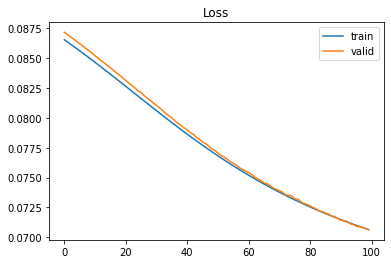

In [6]:
plt.plot(loss_train, label="train")
plt.plot(loss_valid, label="valid")
plt.title("Loss")
plt.legend()
plt.show()

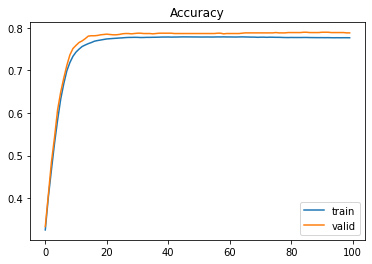

In [7]:
plt.plot(correct_train, label="train")
plt.plot(correct_valid, label="valid")
plt.title("Accuracy")
plt.legend()
plt.show()